In [1]:
import os
import sys
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'src'))

from pathlib import Path
import cv2
import numpy as np
import json
import matplotlib.pyplot as plt
from sympy import Point, Polygon
from utils import *
from FCM import FCM
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import segmentation_models_pytorch as smp

import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image

/home/khoa-ys/Projects/venv_for_projects/bio_ml_venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Visualize shortened dataset:
root_path = os.path.dirname(os.getcwd())
data_path = os.path.join(root_path, "shortened_dataset")
image_dict = json.load(open(os.path.join(data_path, 'image_dict.json'), 'r'))
print(*image_dict.keys(), sep=', ')

Astrocitoma, Carcinoma, Ependimoma, Germinoma, Glioblastoma, Meduloblastoma, Meningioma, Neurocitoma, Oligodendroglioma, Papiloma, Schwannoma, Tuberculoma, _NORMAL


#### Segmentation by contour:

In [3]:
data_path = os.path.join(root_path, "shortened_dataset")
image_dict = json.load(open(os.path.join(data_path, 'image_dict.json'), 'r'))
new_data_path = os.path.join(root_path, "stretched_and_segmented_dataset")
if not os.path.exists(new_data_path):
    os.mkdir(new_data_path)
    
contour_image_dict = {}
for i in range(len(image_dict.keys())):
    tumor_type = list(image_dict.keys())[i]
    for image_name in image_dict[tumor_type]:
        image_path = os.path.join(data_path, image_name)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
             
        contrasted_1 = contrast_stretching(image)
        contrasted_2 = contrast_stretching(contrasted_1)
        contours, chosen_contour = visualize_5_largest_contour(contrasted_1)
        #print(chosen_contour)
        
        if chosen_contour is not None:
            blank = image.copy()
            cv2.polylines(img=blank, pts=[chosen_contour],
                    isClosed=True, color=(255), thickness=2)
            
            """
            blank = np.zeros(image.shape, np.uint8)
            cv2.drawContours(blank, chosen_contour, -1, color=(255, 255, 255), thickness=cv2.FILLED)
            filtered_img = cv2.bitwise_and(image, blank)
            # Crop image to only bounding box
            x, y, w, h = cv2.boundingRect(np.array(chosen_contour))
            filtered_img = filtered_img[y: y + h, x: x + w].copy()
            """
        else:
            continue
        
        dest = os.path.join(new_data_path, image_name.split('/')[0])
        if not os.path.exists(dest):
            os.mkdir(dest)
        new_image_name = image_name.split('/')[1][:-4]+'.png'
        
        #cv2.imwrite(os.path.join(dest, new_image_name), blank)
        contour_image_dict[image_name] = chosen_contour.tolist()
    #plt.figure()
    #plt.imshow(blank)
    #plt.show()
#json.dump(contour_image_dict, open(os.path.join(new_data_path, "contour_image_dict.json"), "w"))

#### Segmentation by K-means and Fuzzy C-means

##### K-means and Fuzzy C-means comparison

In [4]:
def extract_one_cluster(image, cluster_number):
    return (image == cluster_number).astype(np.uint8)*255

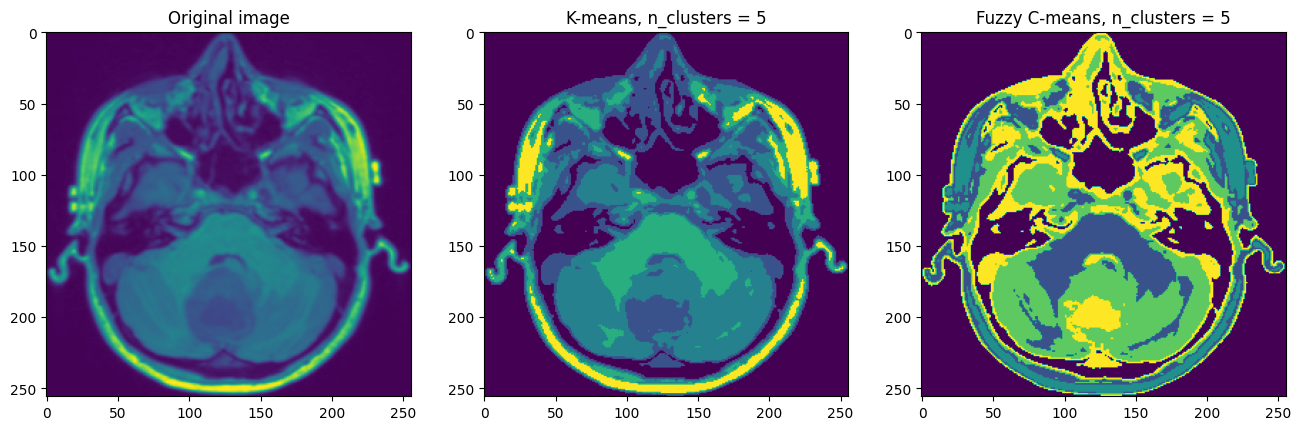

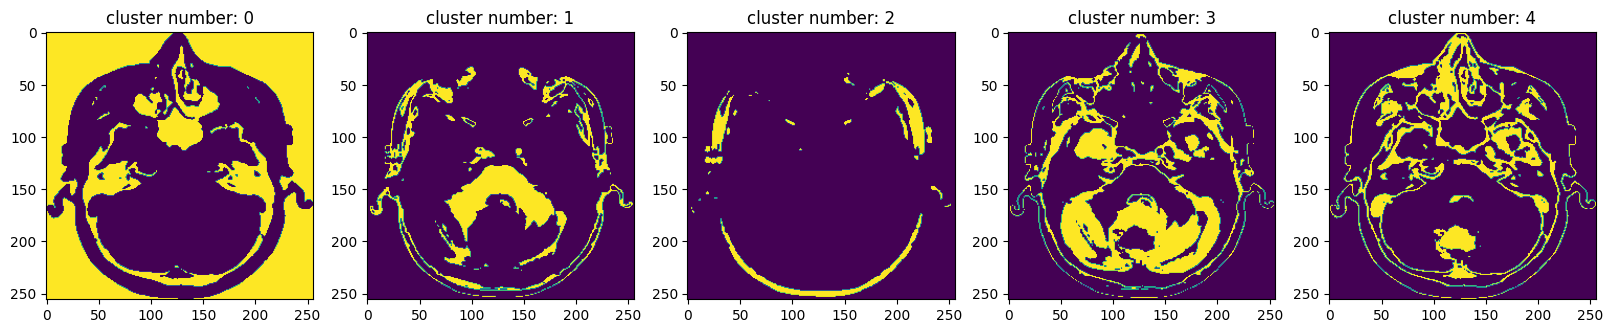

In [10]:
image_path = '/media/khoa-ys/Personal/Projects/ML in Bioinformatics/brain-tumor-classification/shortened_dataset/Astrocitoma T1/astro_infraT (19).png'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
n_clusters = 5

# k-means clustering
vectorized = image.reshape((-1,1))
kmeans = KMeans(n_clusters=n_clusters, random_state = 0, n_init=5).fit(vectorized)
centers = np.uint8(kmeans.cluster_centers_)
segmented_data = centers[kmeans.labels_.flatten()]
k_means_image = segmented_data.reshape((image.shape))

# c-means clustering
cluster = FCM(image, image_bit=8, n_clusters=n_clusters, m=2, epsilon=0.05, max_iter=100, verbose=False)
cluster.form_clusters()
c_means_image = cluster.result

fig, ax = plt.subplots(1, 3, figsize=(16, 6))
ax[0].imshow(image)
ax[0].title.set_text('Original image')
ax[1].imshow(k_means_image)
ax[1].title.set_text('K-means, n_clusters = ' + str(n_clusters))
ax[2].imshow(c_means_image)
ax[2].title.set_text('Fuzzy C-means, n_clusters = ' + str(n_clusters))

fig, ax = plt.subplots(1, n_clusters, figsize=(4*n_clusters, 6))
for i in range(n_clusters):
    ax[i].imshow(extract_one_cluster(c_means_image, i))
    ax[i].title.set_text('cluster number: ' + str(i))
    


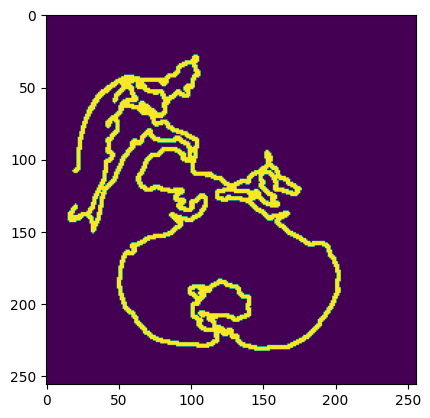

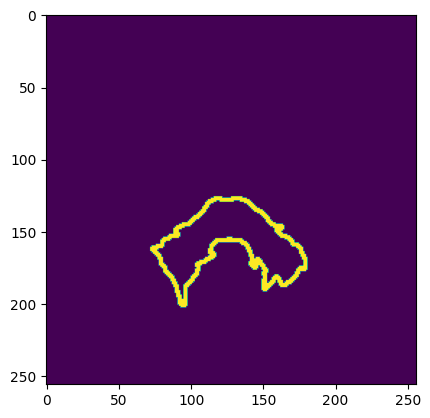

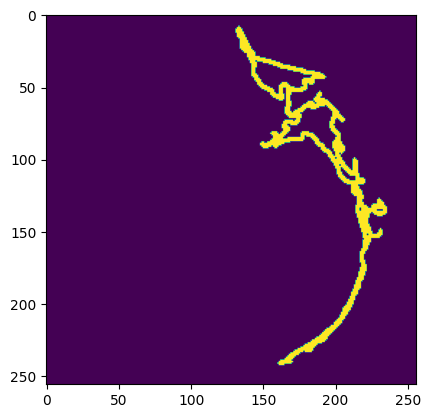

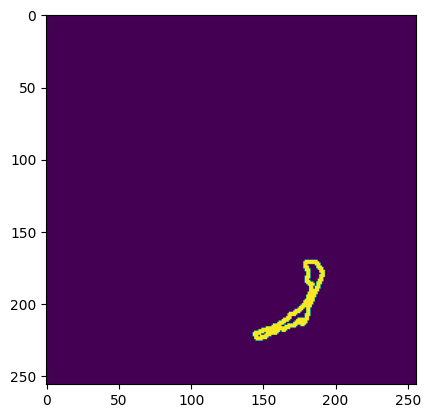

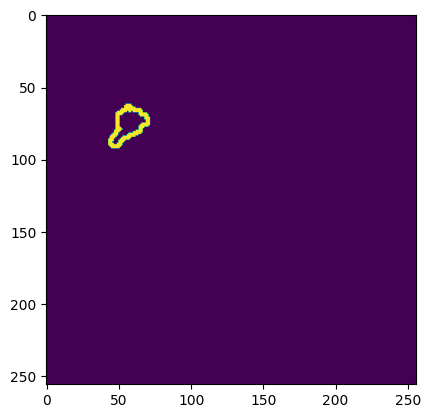

In [11]:
contours, chosen_contour = visualize_5_largest_contour(extract_one_cluster(c_means_image, 3))
for contour in contours:
    blank = np.zeros_like(image)
    cv2.polylines(img=blank, pts=[contour],
            isClosed=True, color=(255), thickness=2)
    plt.figure()
    plt.imshow(blank)

#### Segmentation by pretrained Unet

In [ ]:
class BrainTumorDataset(Dataset):
    def __init__(self, image_dict, data_path, transform=None, transform_label=None):
        self.data_path = data_path
        self.image_dict = image_dict
        self.classes = list(image_dict.keys())
        self.image_class_list = [(item, key) for key, item_list in image_dict.items() for item in item_list]
        self.transform = transform
        self.transform_label = transform_label

    def __len__(self):
        return len(self.image_class_list)

    def __getitem__(self, idx):
        label = self.classes.index(self.image_class_list[idx][1])
        img_path = os.path.join(self.data_path, self.image_class_list[idx][0])
        image = cv2.imread(img_path, 0)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        if self.transform:
            image = self.transform(image)
        if self.transform_label:
            label = self.transform_label(label)
        return image, label

In [ ]:
batch_size = 1

dataset = BrainTumorDataset(image_dict, data_path, transform=transforms.ToTensor())
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
model = smp.Unet(encoder_name='resnet34', encoder_weights='imagenet', classes=5, activation='softmax')
features, labels = next(iter(dataloader))
pred = model(features)

pred

In [ ]:
TRAINING = False

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss = smp.utils.losses.DiceLoss()

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]